# Tree Crown Detection

The delineation of individual trees in remote sensing images is an key task in forest analysis. As part of Sebastian Hickman's AI4ER MRes project, titled 'Detecting changes in tall tree height with machine learning, LiDAR, and RGB imagery', the authors propose the `detectreeRGB` model, an implementation of Mask R-CNN from [Detectron2](https://github.com/facebookresearch/detectron2) to perform tree crown delineation from RGB imagery.

<img src="https://github.com/shmh40/detectreeRGB/blob/main/imgs/plot_13_285520_583300.jpg?raw=true" width="400">

**Figure 1** Example image of the predictions made by Mask R-CNN. Source: [Hickman et al. (2021)](https://github.com/shmh40/detectreeRGB).

<div class="alert alert-block alert-info">
     <p>   
        In this notebook, we'll walk through how scivision can assist in discovering a pretrained detectreeRGB model provided by Hickman et al (2021), and then use it to delineate crowns from a sample drone RGB image dataset.
    </p> 
    <p>    
    Further details of the detectreeRGB can be found in 
        <a href="https://github.com/shmh40/detectreeRGB/"> the original model repository</a>.
    </p>     
</div>

## Load libraries

In [1]:
!pip install opencv-python-headless #hide only if the notebook runs in standard desktop environments

In [2]:
from scivision.catalog import default_catalog
from scivision.io import load_dataset, load_pretrained_model
from intake_zenodo_fetcher import download_zenodo_files_for_entry

## Catalog
We'll use the detectreeRGB model which is registered in the `scivision` model catalog as `detectreeRGB-forest`. Then we'll look with compatible_datasources potential data entries registered in the scivision data catalog with tasks and format compatible with the model.

In [3]:
model_name = 'detectreeRGB-forest'

In [4]:
compatible_datasources = default_catalog.compatible_datasources(model_name).to_dataframe()

This returns a `pandas.dataframe` with the number of potential datasets to pair the model with.

In [5]:
compatible_datasources

,name,description,tasks,domains,url,format,labels_provided,institution,tags
0,data-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...","(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,True,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...","(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,True,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
3,data-003,Koala,"(TaskEnum.object_detection, TaskEnum.classific...","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"
5,data-005,Sample dataset of satellite imagery required t...,"(TaskEnum.classificiation, TaskEnum.segmentation)","(computer-vision, earth-observation, ecology)",https://github.com/MartinSJRogers/VEdge_Detect...,image,False,"(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."
6,data-006,Sample dataset of drone RGB imagery required t...,"(TaskEnum.object_detection, TaskEnum.segmentat...","(computer-vision, earth-observation, ecology)",https://github.com/shmh40/detectreeRGB-treecro...,image,False,"(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."


## Model
The following lines will look for the model URL (in this case the GitHub repository) from the scivision model catalog. After, the `load_pretrained_model` function will recognise the URL and install dependencies if they are not yet in the current virtual environment.

In [6]:
models = default_catalog.models.to_dataframe()
targetmodel = models[models.name == model_name].url.item()
model = load_pretrained_model(targetmodel, allow_install=True)

In [7]:
model

scivision.PretrainedModel( 
  module='detectreeRGB_treecrown_scivision', 
  model='DetectreeRGB', 
  source='https://github.com/acocac/detectreeRGB-treecrown-scivision' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Data

We'll load one of the suggested datasets in compatible_datasources. In this case, we will use the dataset registered with the name field equals to data-006. This refers to a drone image dataset kindly shared by Hickman et al. in a [zenodo repository](https://zenodo.org/record/5090039#.Ys_rxC8w1pQ) to demonstrate the `detectreeRGB` model.

In [8]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-006']
target_datasource

,name,description,tasks,domains,url,format,labels_provided,institution,tags
6,data-006,Sample dataset of drone RGB imagery required t...,"(TaskEnum.object_detection, TaskEnum.segmentat...","(computer-vision, earth-observation, ecology)",https://github.com/shmh40/detectreeRGB-treecro...,image,False,"(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."


In [9]:
cat = load_dataset(target_datasource.url.item()) 
download_zenodo_files_for_entry(cat.sepilok_rgb, force_download=False)
dataset = cat.sepilok_rgb().to_dask()

In dataset, the sample image, which actually has an RGB bands plus additional band, is loaded into single `xarray.Dataset` object with a defined dimension, in this case 1400 px x 1400 px. 

In [10]:
dataset

<xarray.DataArray (band: 4, y: 1400, x: 1400)>
array([[[36166.285 , 34107.22  , ..., 20260.998 , 11166.631 ],
        [32514.84  , 28165.994 , ..., 24376.36  , 21131.947 ],
        ...,
        [15429.493 , 16034.794 , ..., 19893.691 , 19647.646 ],
        [12534.722 , 14003.215 , ..., 21438.908 , 22092.525 ]],

       [[38177.168 , 36530.74  , ..., 19060.268 , 11169.006 ],
        [34625.227 , 30270.379 , ..., 21760.09  , 20796.621 ],
        ...,
        [17757.678 , 16818.102 , ..., 22538.023 , 23093.508 ],
        [13403.302 , 13354.489 , ..., 24638.21  , 25545.938 ]],

       [[13849.501 , 14158.603 , ...,  9385.764 ,  7401.662 ],
        [13252.31  , 13373.801 , ..., 12217.845 , 10666.252 ],
        ...,
        [13471.741 , 11533.697 , ...,  7536.6924,  8397.009 ],
        [13724.59  , 11057.722 , ...,  9778.8125, 11174.72  ]],

       [[65535.    , 65535.    , ..., 65535.    , 65535.    ],
        [65535.    , 65535.    , ..., 65535.    , 65535.    ],
        ...,
        [65535.    , 65535.    , ..., 65535.    , 65535.    ],
        [65535.    , 65535.    , ..., 65535.    , 65535.    ]]], dtype=float32)
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 6.467e+05 6.467e+05 6.467e+05 ... 6.466e+05 6.466e+05
  * x        (x) float64 6.025e+05 6.025e+05 6.025e+05 ... 6.026e+05 6.026e+05
Attributes:
    transform:      (0.1, 0.0, 602480.0, 0.0, -0.1, 646720.0)
    crs:            +init=epsg:32650
    res:            (0.1, 0.1)
    is_tiled:       0
    nodatavals:     (-3.3999999521443642e+38, -3.3999999521443642e+38, -3.399...
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

## Prediction and visualisation
Once we load model and data, we will use the predict function previously defined within the scivision configuration file of the model. In this example, the predict function goes over the RGB bands of the image and we enable the `plot` argument to plot the predictions over the drone RGB image. If we set `plot=False`, it will only return the instance values which can be then plotted as it is indicated in the example of detectreeRGB in the Environmental Data Science book (see [here](https://the-environmental-ds-book.netlify.app/gallery/modelling/forest-modelling-treecrown_detectreergb/forest-modelling-treecrown_detectreergb#showing-the-predictions-from-detectreergb)).

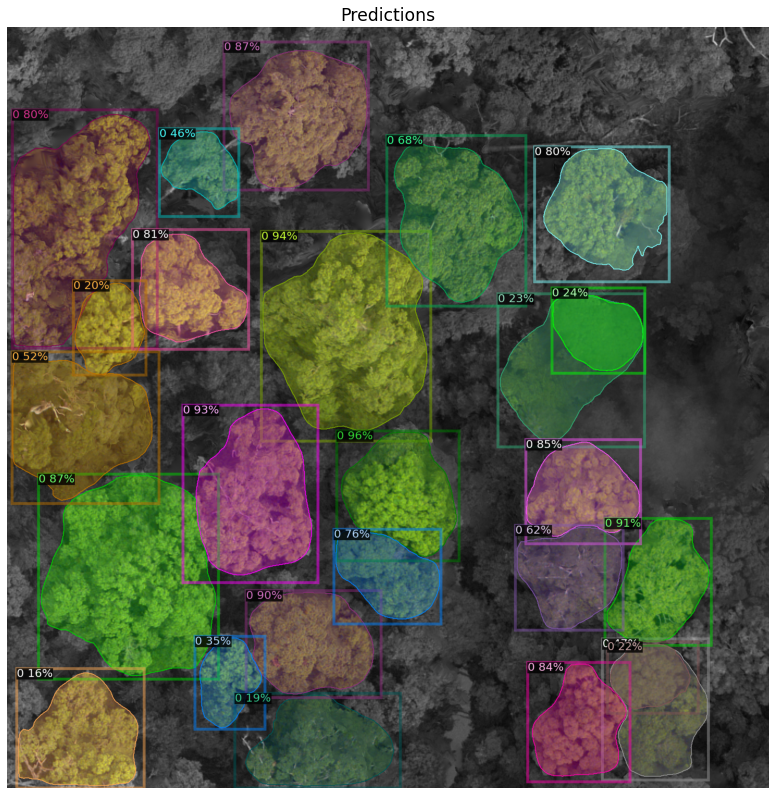

In [11]:
y = model.predict(dataset.sel(band=slice(1,3)), plot=True)